<a href="https://colab.research.google.com/github/rohanx01/ME-228-COURSE-PROJECT/blob/main/Copy_of_music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
audio_data = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00096.wav'
data , sr = librosa.load(audio_data)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio_data, sr=45000)

(array([-0.08003321, -0.10602735, -0.09903553, ..., -0.06337988,
        -0.0562089 , -0.0281919 ], dtype=float32),
 45000)

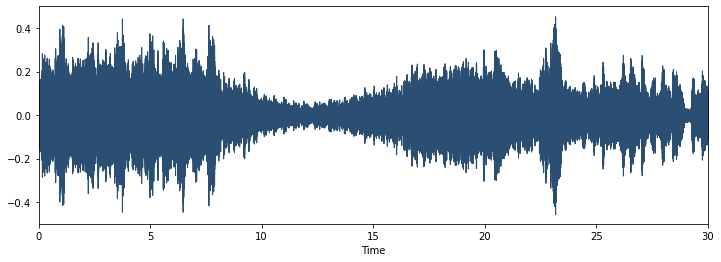

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, color = "#2B4F72")
plt.show()

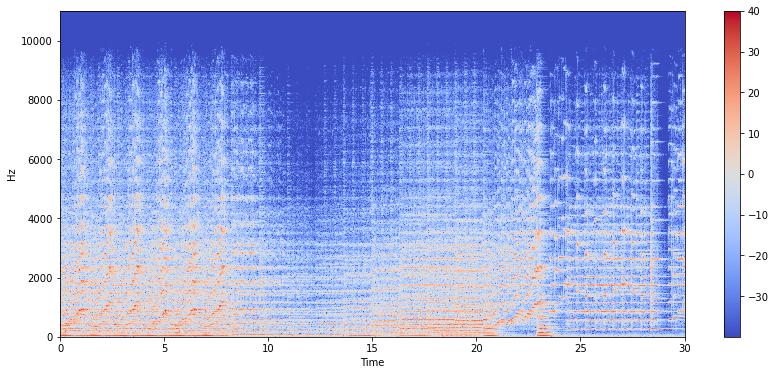

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.


Let's Convert the frequency axis to a logarithm , because we see that all actions (in red) is taking place at the bottom of the spectrum.

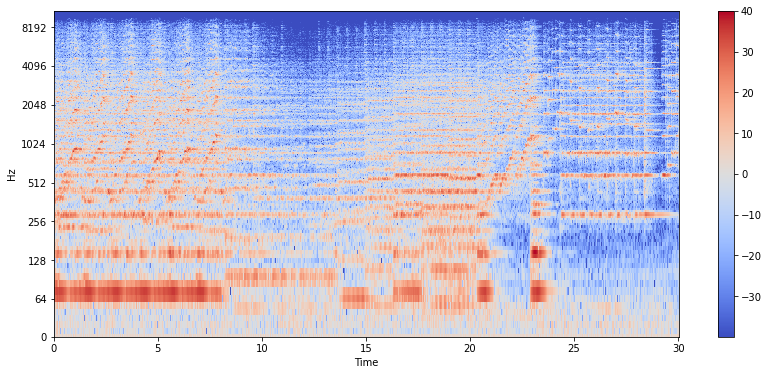

In [ ]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

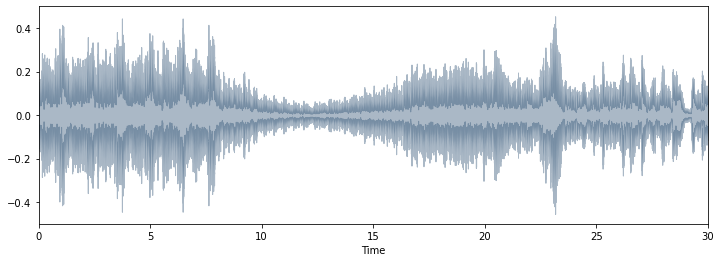

In [ ]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color = "#2B4F72")

**Classification**

Our Datasets contains 10 genres :
*   Blues
*   Classical
*   Country
*   Disco
*   Hiphop
*   Jazz
*   Metal
*   Pop
*   Reggae
*   Rock

In [ ]:
%matplotlib inline
from keras import layers
import keras

In [ ]:
df1 = pd.read_csv('../input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df1.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
df1.shape

(9990, 60)

In [ ]:
df1.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

We will drop the first column of "filename":

In [ ]:
df1 = df1.drop(labels='filename',axis=1)

**Preprocessing the Data**

We will now focus on the last column "label" the categorical column and we will try to encode it with the function LabelEncoder() of sklearn.preprocessing.

In [ ]:
genre_list = df1.iloc[:, -1]
encoder = LabelEncoder()

In [ ]:
y = encoder.fit_transform(genre_list)

In [ ]:
print(df1.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(7992, 58)
(7992,)


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test=torch.tensor(X_test, dtype=torch.float32)
y_test=torch.tensor(y_test, dtype=torch.int64)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)


In [ ]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
valset=TensorDataset(X_test, y_test)
val= DataLoader(valset, batch_size=128, shuffle=True)

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])# Use only the last output
        out = self.softmax(out)
        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
input_size = X_train.shape[2]
hidden_size = 64
num_classes = 10
model = RNNClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = running_val_loss / total_val
    epoch_val_acc = correct_val / total_val

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

Epoch [1/100], Train Loss: 2.1902, Train Acc: 0.3422, Val Loss: 2.1012, Val Acc: 0.3674
Epoch [2/100], Train Loss: 2.0491, Train Acc: 0.4373, Val Loss: 2.0157, Val Acc: 0.4735
Epoch [3/100], Train Loss: 1.9750, Train Acc: 0.5329, Val Loss: 1.9567, Val Acc: 0.5450
Epoch [4/100], Train Loss: 1.9234, Train Acc: 0.5861, Val Loss: 1.9185, Val Acc: 0.5826
Epoch [5/100], Train Loss: 1.8862, Train Acc: 0.6226, Val Loss: 1.8878, Val Acc: 0.6086
Epoch [6/100], Train Loss: 1.8547, Train Acc: 0.6584, Val Loss: 1.8640, Val Acc: 0.6356
Epoch [7/100], Train Loss: 1.8300, Train Acc: 0.6803, Val Loss: 1.8408, Val Acc: 0.6572
Epoch [8/100], Train Loss: 1.8096, Train Acc: 0.6957, Val Loss: 1.8234, Val Acc: 0.6777
Epoch [9/100], Train Loss: 1.7940, Train Acc: 0.7066, Val Loss: 1.8098, Val Acc: 0.6867
Epoch [10/100], Train Loss: 1.7813, Train Acc: 0.7186, Val Loss: 1.7985, Val Acc: 0.6937
Epoch [11/100], Train Loss: 1.7700, Train Acc: 0.7267, Val Loss: 1.7907, Val Acc: 0.7002
Epoch [12/100], Train Loss: 1.